# TensorFlow multi-input Pet Pawpularity Model

## Table of Contents
- Summary
- Set up
- Import datasets
- Data Preprocessing
- Model Development
- Model Evaluation
- Submission


## Summary
In this notebook, I will build a TensorFlow multi-input Model that can receive image inputs and tabular inputs at the same time for training, so that I can get the most out of this dataset.
## Set up

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

## Import datasets

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

## Data Preprocessing

In [3]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [4]:
train["file_path"] = train["Id"].apply(lambda identifier: "train/" + identifier + ".jpg")
test["file_path"] = test["Id"].apply(lambda identifier: "test/" + identifier + ".jpg")

In [10]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,train/0007de18844b0dbbb5e1f607da0606e0.jpg
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,train/0009c66b9439883ba2750fb825e1d7db.jpg
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,train/0013fd999caf9a3efe1352ca1b0d937e.jpg
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,train/0018df346ac9c1d8413cfcc888ca8246.jpg
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,train/001dc955e10590d3ca4673f034feeef2.jpg


<AxesSubplot:>

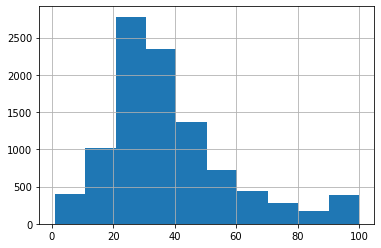

In [11]:
train["Pawpularity"].hist()

## Model Development

In [5]:
tabular_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
image_size = 128
batch_size = 128

In [13]:
def preprocess(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return (image, tabular[1:]), tabular[0]

In [15]:
a = train.loc[1, ["Pawpularity"] + tabular_columns]

In [16]:
type(a)

pandas.core.series.Series

In [17]:
preprocess("train/0007de18844b0dbbb5e1f607da0606e0.jpg",a)

((<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
  array([[[0.47159067, 0.45982596, 0.5029632 ],
          [0.41024145, 0.39847675, 0.441614  ],
          [0.4042203 , 0.3924556 , 0.43559286],
          ...,
          [0.7097398 , 0.7188084 , 0.75973976],
          [0.70862824, 0.7216596 , 0.7536803 ],
          [0.69903684, 0.71080154, 0.7411937 ]],
  
         [[0.7035482 , 0.703058  , 0.7425188 ],
          [0.67488223, 0.67439204, 0.7138528 ],
          [0.65424615, 0.6537559 , 0.6932167 ],
          ...,
          [0.6296588 , 0.6511336 , 0.6355479 ],
          [0.65810263, 0.6649194 , 0.66986734],
          [0.66543925, 0.6691157 , 0.67695886]],
  
         [[0.74648535, 0.75825006, 0.7935442 ],
          [0.7377882 , 0.7495529 , 0.784847  ],
          [0.75046915, 0.76223385, 0.79752797],
          ...,
          [0.5839049 , 0.67900294, 0.5131482 ],
          [0.58567905, 0.65895474, 0.50839657],
          [0.6061418 , 0.67550457, 0.51447517]],
  
         ...,
  
     

In [4]:
def block(x, filters, kernel_size, repetitions, pool_size=2, strides=2):
    for i in range(repetitions):
        x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)
    return x

In [5]:
def get_model():
    image_inputs = tf.keras.Input((image_size, image_size , 3))
    tabular_inputs = tf.keras.Input(len(tabular_columns))
    image_x = block(image_inputs, 8, 3, 2)
    image_x = block(image_x, 16, 3, 2)
    image_x = block(image_x, 32, 3, 2)
    image_x = block(image_x, 64, 3, 2)
    image_x = block(image_x, 128, 3, 2)
    image_x = tf.keras.layers.GlobalAveragePooling2D()(image_x)
    
    tabular_x = tf.keras.layers.Dense(16)(tabular_inputs)
    tabular_x = tf.keras.layers.Dense(16)(tabular_x)
    tabular_x = tf.keras.layers.Dense(16)(tabular_x)
    tabular_x = tf.keras.layers.Dense(
        16, 
        activation="relu", 
        kernel_regularizer=tf.keras.regularizers.l2()
    )(tabular_x)
    
    x = tf.keras.layers.Concatenate(axis=1)([image_x, tabular_x])
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[image_inputs, tabular_inputs], outputs=[output])
    return model

Let's have a big picture of how this Model looks like.

In [ ]:
model =  get_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 8)    0           conv2d_1[0][0]                   
______________________________________________________________________________________________

This Model accepts images with shape (image_size, image_size, 3) and tabular information with shape (12) as input. Since it's a Regression problem, it generate output with shape (1). 

In [12]:
image = np.random.normal(size=(1, image_size, image_size, 3))
tabular = np.random.normal(size=(1, len(tabular_columns)))
print(image.shape, tabular.shape)
print(model((image, tabular)).shape)

(1, 128, 128, 3) (1, 12)
(1, 1)


### Model Training
I will use tensorflow Dataset here to preprocess and cache tensors, first epoch is very slow because it's preprocessing data; after that, it would be much faster.

In [6]:
kfold = KFold(n_splits=5, shuffle=True, random_state=997)
a = enumerate(kfold.split(train))

In [7]:
for i in a:
    i1, i2 = i
    break

In [8]:
i1

0

In [9]:
train_a, valid_a = i2

In [10]:
print(train_a.shape)
print(valid_a.shape)

(7929,)
(1983,)


In [12]:
valid_a

array([   0,   11,   15, ..., 9900, 9901, 9904])

In [11]:
train.loc[valid_a, 'file_path']

0       train/0007de18844b0dbbb5e1f607da0606e0.jpg
11      train/00524dbf2637a80cbc80f70d3ff59616.jpg
15      train/0067aaaa500b530c76b9c91af34b4cb8.jpg
17      train/006fe962f5f7e2c5f527b2e27e28ed6d.jpg
18      train/0075ec6503412f21cf65ac5f43d80440.jpg
                           ...                    
9892    train/ff3410ab3513641567039f0a443d91dc.jpg
9897    train/ff6591fb1b3481fe0c366dfdcdc8ab5f.jpg
9900    train/ff75490f8f99867fc9dec1c298e0761a.jpg
9901    train/ff76db2a10b7bc5a3217ccb083e87e75.jpg
9904    train/ff9b3b3468c4b35a3b6450a1ddc88449.jpg
Name: file_path, Length: 1983, dtype: object

Epoch 1/300
62/62 [==============================] - 107s 2s/step - loss: 613.9496 - rmse: 24.7748 - mae: 18.4592 - mape: 81.2180 - val_loss: 440.0811 - val_rmse: 20.9744 - val_mae: 14.7786 - val_mape: 60.7233
Epoch 2/300
62/62 [==============================] - 63s 1s/step - loss: 452.0246 - rmse: 21.2573 - mae: 15.8467 - mape: 80.3438 - val_loss: 442.9599 - val_rmse: 21.0431 - val_mae: 14.6478 - val_mape: 59.0391
Epoch 3/300
62/62 [==============================] - 66s 1s/step - loss: 439.8766 - rmse: 20.9698 - mae: 15.6810 - mape: 80.7734 - val_loss: 422.9290 - val_rmse: 20.5618 - val_mae: 14.6310 - val_mape: 62.5609
Epoch 4/300
62/62 [==============================] - 64s 1s/step - loss: 434.4011 - rmse: 20.8389 - mae: 15.6057 - mape: 80.9205 - val_loss: 419.8231 - val_rmse: 20.4862 - val_mae: 14.6015 - val_mape: 63.0099
Epoch 5/300
62/62 [==============================] - 66s 1s/step - loss: 432.9731 - rmse: 20.8047 - mae: 15.5853 - mape: 80.9744 - val_loss: 428.4319 - val_rmse: 2

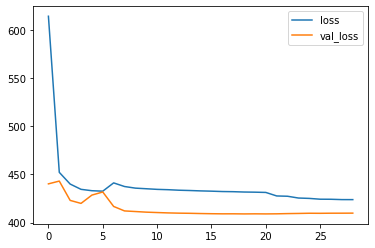

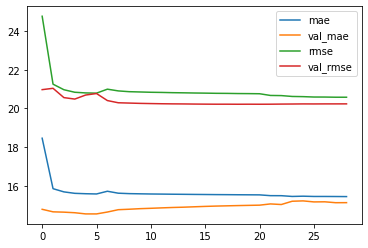

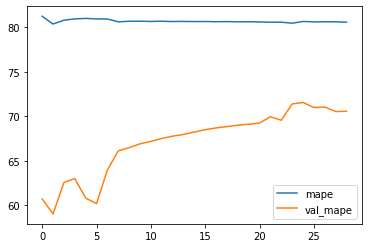

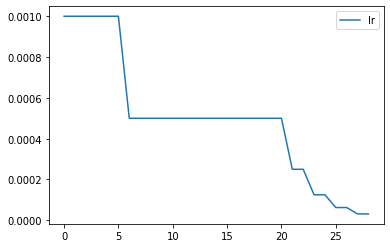

In [13]:
tf.keras.backend.clear_session()
models = []
historys = []
kfold = KFold(n_splits=5, shuffle=True, random_state=997)
# For the current random state, 5th fold can generate a better validation rmse and faster convergence.
train_best_fold = True
best_fold = 4
for index, (train_indices, val_indices) in enumerate(kfold.split(train)):
    if train_best_fold and index != best_fold:
        continue
    x_train = train.loc[train_indices, "file_path"]
    tabular_train = train.loc[train_indices, ["Pawpularity"] + tabular_columns]
    x_val= train.loc[val_indices, "file_path"]
    tabular_val = train.loc[val_indices, ["Pawpularity"] + tabular_columns]
    checkpoint_path = "model_%d.h5"%(index)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        save_best_only=True
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        min_delta=1e-4, 
        patience=10
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=2, 
        min_lr=1e-7
    )
    callbacks = [early_stop, checkpoint, reduce_lr]
    
    loss = tf.keras.losses.MeanSquaredError()
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, tabular_train)).map(preprocess).shuffle(512).batch(batch_size).cache().prefetch(2)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, tabular_val)).map(preprocess).batch(batch_size).cache().prefetch(2)
    model = get_model()
    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae", "mape"])
    history = model.fit(train_ds, epochs=300, validation_data=val_ds, callbacks=callbacks)
    for metrics in [("loss", "val_loss"), ("mae", "val_mae", "rmse", "val_rmse"), ("mape", "val_mape"), ["lr"]]:
        pd.DataFrame(history.history, columns=metrics).plot()
        plt.show()
    model.load_weights(checkpoint_path)
    historys.append(history)
    models.append(model)

## Submission

In [14]:
def preprocess_test_data(image_url, tabular):
    print(image_url, tabular)
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    # 0 won't be used in prediction, but it's needed in this senario or the tabular variable is treated as label.
    return (image, tabular), 0

In [15]:
test_ds = tf.data.Dataset.from_tensor_slices((test["file_path"], test[tabular_columns])).map(preprocess_test_data).batch(batch_size).cache().prefetch(2)

Tensor("args_0:0", shape=(), dtype=string) Tensor("args_1:0", shape=(12,), dtype=int64)


In [16]:
use_best_result = True
if use_best_result:
    if train_best_fold:
        best_model = models[0]
    else:
        best_fold = 0
        best_score = 10e8
        for fold, history in enumerate(historys):
            for val_rmse in history.history["val_rmse"]:
                if val_rmse < best_score:
                    best_score = val_rmse
                    best_fold = fold
        print("Best Score:%.2f Best Fold: %d"%(best_score, best_fold + 1))
        best_model = models[best_fold]
    sample_submission["Pawpularity"] = best_model.predict(test_ds).reshape(-1)
    sample_submission.to_csv("submission.csv", index=False)
else:
    total_results = []
    for model in models:
        total_results.append(model.predict(test_ds).reshape(-1))
    results = np.mean(total_results, axis=0).reshape(-1)
    sample_submission["Pawpularity"] = results
    sample_submission.to_csv("submission.csv", index=False)